# Librairies Utilisées

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopy.distance
import numpy

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from functools import reduce

import seaborn as sns
import matplotlib.pyplot as plt

from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

/Users/safadjerir/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Dans le cadre de notre étude, nous avons prévu de charger et de fusionner quatre tables de données pour construire une seule table qui contiendra l'ensemble de nos données. Nous avons décidé de ne pas utiliser la table des vacances pour le moment, mais nous pourrons peut-être l'intégrer ultérieurement si nécessaire. Cette opération de fusion des tables nous permettra de disposer d'un jeu de données complet et cohérent, qui nous servira de base pour notre analyse.

In [2]:
holidays = pd.read_csv("holidays.csv")
places = pd.read_csv("places.csv",low_memory=False)
users = pd.read_csv("users.csv")
vehicles = pd.read_csv("vehicles.csv")
caracteristics = pd.read_csv("caracteristics.csv",encoding='latin-1',low_memory=False)

# Nettoyage des données 

Dans cette partie de notre étude, nous avons décidé de consacrer du temps et des efforts pour nettoyer les données et nous assurer que nous ne retenons que les informations qui sont importantes et pertinentes pour notre analyse. Cela nous permettra de travailler avec des données de qualité et de minimiser les erreurs ou les biais qui pourraient affecter nos résultats. Nous estimons que cette étape est cruciale pour obtenir des résultats précis et fiables.

Nous avons décidé de nous concentrer sur les accidents qui se sont produits en France métropolitaine. Cette décision s'explique par le fait que nous estimons que les départements d'outre-mer ont des caractéristiques de routes et de climat qui peuvent différer de celles de la France métropolitaine et qui pourraient influencer les résultats de notre analyse. En limitant notre étude aux accidents survenus en France métropolitaine, nous espérons obtenir des résultats plus pertinents et plus fiables.

In [3]:
# Limitons l'échelle de l'étude sur la France Métropolitaine
domtom = [971,972,973,974,976,975]
caracteristics = caracteristics[~caracteristics.dep.isin(domtom)]
caracteristics = caracteristics[caracteristics.gps != "A"] # drop des Antilles

Nous allons fusionner les bases de données qui contiennent des informations sur les accidents de la route. Le champ commun entre ces bases de données est le numéro d'accident, qui est unique pour chaque accident.

Pour vérifier la qualité des données après la fusion, nous allons comparer le nombre d'usagers avant et après la fusion. Si le nombre d'usagers n'a pas changé, cela indique que la fusion s'est déroulée correctement et que les données sont de qualité.

In [4]:
Merging = [caracteristics,users,places]
accidents = reduce(lambda left,right: pd.merge(left,right,on=['Num_Acc'],how='left'),Merging)
Merging = [accidents,vehicles]
accidents = reduce(lambda left,right: pd.merge(left,right,on=['Num_Acc','num_veh'],how='left'),Merging)

### Traitement des valeurs manquantes 

Nous allons écrire une fonction qui nous montrera le nombre de valeurs manquantes pour chaque variable, ainsi que le pourcentage de valeurs manquantes associé à chaque variable.

In [5]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [6]:
missing_values_table(accidents)

Your selected dataframe has 51 columns.
There are 38 columns that have missing values.


,Missing Values,% of Total Values
v2,1737136,95.7
v1,1091916,60.2
long,1013095,55.8
lat,1013085,55.8
gps,1007162,55.5
pr1,892223,49.1
pr,889725,49.0
adr,322766,17.8
voie,121608,6.7
place,96999,5.3


In [7]:
accidents = accidents.drop(['v1', 'v2', 'pr', 'pr1', 'lartpc', 'adr', 'voie','long','lat',
                            'gps','locp', 'actp', 'etatp','larrout','env1','vosp','place',
                            'manv','obsm','obs','senc'], axis=1)

- Nous avons constaté que plus de 50% des valeurs de certaines variables sont manquantes, notamment pour les variables suivantes : 'v1', 'v2', 'long', 'lat', 'gps', 'pr', 'pr1'. Nous estimons que ces variables ne sont pas importantes pour notre étude et nous décidons de les ignorer.
- En ce qui concerne les variables 'adr' et 'voie', qui décrivent les détails de l'adresse de l'accident, nous décidons de ne conserver que le code postal, qui nous semble plus pertinent.
- La variable 'place' décrit l'endroit où se trouvait chaque passager dans l'automobile au moment de l'accident. Cependant, cette information est déjà couverte par la variable 'catu', nous décidons donc de supprimer 'place' pour éviter la redondance d'informations.
- Les variables 'actp' et 'locp' décrivent les caractéristiques des piétons impliqués dans l'accident, mais comme la plupart de nos accidents ne concernent pas de piétons, ces variables sont trop détaillées et spécifiques pour être utiles.
- Les variables 'larrout' et 'lartpc' ne sont pas très bien comprises.
- La variable 'env1' décrit la proximité de l'accident par rapport à une école, mais dans la plupart de nos accidents, nous sommes loin des écoles, cette variable n'est donc pas pertinente.
- La variable 'vosp' qui ndique l'existence d'une voie réservée, qu'il y ait eu un accident sur cette voie ou non est très spécifique.
- Enfin, les variables 'manv', 'obsm', 'obs', 'senc' sont soit trop détaillées, soit pas assez bien comprises pour être utiles dans notre étude. Nous décidons donc de les ignorer.

Après avoir examiné plusieurs techniques pour traiter les valeurs manquantes (comme les supprimer ou les remplacer par la moyenne), nous avons décidé de les remplacer par la médiane dans chaque colonne correspondante. Cette approche consiste à fusionner les modalités "0" avec la modalité la plus fréquente.

In [8]:
# replace nan by mode
for i in accidents.columns:
    accidents[i].fillna(accidents[i].mode()[0], inplace=True)

Au cours de cette étape de notre étude, nous avons estimé qu'il serait utile de fusionner et de renommer certaines modalités des variables qui nous intéressent, afin de mieux comprendre leur signification et de mieux interpréter les résultats de notre analyse. Cela nous permettra de progresser dans notre étude et d'en tirer des conclusions plus précises.

In [9]:

accidents['catv'] = accidents['catv'].replace([3,6,8,9,10,11,14,13,15,12,7], 'vehicule')
accidents['catv'] = accidents['catv'].replace([16,21, 17], 'camion')
accidents['catv'] = accidents['catv'].replace([18,19,38,39,37, 40], 'bus')
accidents['catv'] = accidents['catv'].replace([2,30,31,32, 35,36,33, 34], '2roues')
accidents['catv'] = accidents['catv'].replace([4,5, 1], 'velo')
accidents['catv'] = accidents['catv'].replace([20,41,42,43,50,60,80,99], 'autre')

accidents['int'] = accidents['int'].replace([3.0,4.0,5.0,6.0,7.0,8.0], 2.0)

accidents['atm'] = accidents['atm'].replace([5.0,6.0,7.0,8.0, 9.0], "autre")
accidents['atm'] = accidents['atm'].replace(1.0, "normale")
accidents['atm'] = accidents['atm'].replace([2.0,3.0], "pluie")
accidents['atm'] = accidents['atm'].replace(4.0, "neige")


accidents['col'] = accidents['col'].replace(4.0, 5.0) #collision entre 2 véhicule
accidents['col'] = accidents['col'].replace([1.0,2.0], 3.0) #collision entre 3 véhicules

accidents['catr'] = accidents['catr'].replace([5.0,6.0,7.0, 9.0], "autre") #J'ai garder que 4 types de routes
accidents['catr'] = accidents['catr'].replace(1.0, "autoroute")
accidents['catr'] = accidents['catr'].replace(2.0, "route nationale")
accidents['catr'] = accidents['catr'].replace(3.0, "route départementale")
accidents['catr'] = accidents['catr'].replace(4.0, "voie communale")

accidents['surf'] = accidents['surf'].replace([3.0,8.0], 2.0)
accidents['surf'] = accidents['surf'].replace(5.0, 7.0)

accidents['choc'] = accidents['choc'].replace(0.0, "aucun")
accidents['choc'] = accidents['choc'].replace([2.0,3.0, 1.0], "avant")
accidents['choc'] = accidents['choc'].replace([5.0,6.0, 4.0], "arrière")
accidents['choc'] = accidents['choc'].replace(7.0, "droit")
accidents['choc'] = accidents['choc'].replace(8.0, "gauche")
accidents['choc'] = accidents['choc'].replace(9.0, "chocs multiples")

#accidents['sexe'] = accidents['sexe'].replace(1.0, "masculin")
#accidents['sexe'] = accidents['sexe'].replace(2.0, "feminin")

accidents['lum'] = accidents['lum'].replace([0.0,1.0], "plein jour")
accidents['lum'] = accidents['lum'].replace(2.0, "aube")
accidents['lum'] = accidents['lum'].replace(3.0, "nuit sans éclairage public")
accidents['lum'] = accidents['lum'].replace(4.0, "nuit avec éclairage public non allumé")
accidents['lum'] = accidents['lum'].replace(5.0, "nuit avec éclairage public allumé")

accidents['infra'] = accidents['infra'].replace(0.0, "aucun")
accidents['infra'] = accidents['infra'].replace(1.0, "tunnel")
accidents['infra'] = accidents['infra'].replace(2.0, "pont")
accidents['infra'] = accidents['infra'].replace(3.0, "bretelle")
accidents['infra'] = accidents['infra'].replace(4.0, "voie ferrée")
accidents['infra'] = accidents['infra'].replace(5.0, "carrefour aménagé")
accidents['infra'] = accidents['infra'].replace(6.0, "zone pietonne")
accidents['infra'] = accidents['infra'].replace(7.0, "zone de péage")
accidents['infra'] = accidents['infra'].replace(8.0, "chantier")
accidents['infra'] = accidents['infra'].replace(9.0, "autre")
                                                
accidents['catu'] = accidents['catu'].replace([1.0,4.0], "conducteur")
accidents['catu'] = accidents['catu'].replace(2.0, "passager")
accidents['catu'] = accidents['catu'].replace(3.0, "pieton")

accidents['prof'] = accidents['prof'].replace(1.0, "plat")
accidents['prof'] = accidents['prof'].replace(2.0, "pente")
accidents['prof'] = accidents['prof'].replace(3.0, "sommet de côte")
accidents['prof'] = accidents['prof'].replace(4.0, "bas de côte")


accidents = accidents[accidents.nbv <= 10]
accidents = accidents.drop_duplicates()

# ACP et One hot encoding 

Pour effectuer notre analyse en composantes principales (ACP), nous avons sélectionné un sous-ensemble de variables de notre base de données qui avaient été préalablement traitées à l'aide du One Hot Encoding (OHE). Nous avons testé plusieurs combinaisons de variables et avons déterminé que cette combinaison spécifique, comprenant les variables suivantes: ['catv', 'choc', 'catu', 'sexe', 'lum', 'atm', 'catr', 'prof', 'surf'], offrait le pourcentage de variance le plus élevé parmi toutes les autres combinaisons que nous avons testées. Nous avons donc utilisé cette combinaison pour l'ACP.

In [10]:
df_ohe = accidents.drop(['jour','hrmn','com','num_veh','dep','occutc', 'grav', 'trajet'], axis = 1)
df_ohe['an'] = df_ohe['an']+2000
df_ohe['age'] = df_ohe['an'] - df_ohe['an_nais']
selected_columns = ['catv', 'choc', 'catu', 'lum', 'atm', 'catr', 'prof', 'surf']

Dans notre étude, nous avons tenté de stratifier l'âge des personnes afin de l'inclure dans notre analyse. Cependant, malgré nos efforts, nous n'avons pas réussi à obtenir des résultats satisfaisants en utilisant cette variable. Nous avons donc décidé de ne pas l'inclure dans notre étude finale. Nous espérons pouvoir explorer d'autres méthodes pour inclure cette variable importante dans nos analyses futures.

In [11]:
conditions = [
    ((df_ohe['age']>= 0) & (df_ohe['age']< 18)),
    ((df_ohe['age']>= 18) & (df_ohe['age']< 30)),
    ((df_ohe['age']>= 30) & (df_ohe['age']< 50)),
    ((df_ohe['age']>= 50))
     ]
values = ['0_to_18','18_to_30', '30_to_50','>50']
df_ohe['age_inter'] = np.select(conditions, values)

df_ohe['agg']= df_ohe['agg'].replace(2,0)
df_ohe['sexe']=df_ohe['sexe'].replace(2,0)

In [12]:
accidents_ohe = pd.get_dummies(df_ohe, columns =selected_columns)
accidents_ohe = accidents_ohe.drop(['Num_Acc','secu','an','mois','int','col','circ','nbv','plan','situ', 'an_nais','infra','age','agg','age_inter'], axis = 1)
accidents_ohe

,sexe,catv_2roues,catv_autre,catv_bus,catv_camion,catv_vehicule,catv_velo,choc_arrière,choc_aucun,choc_avant,...,prof_pente,prof_plat,prof_sommet de côte,surf_0.0,surf_1.0,surf_2.0,surf_4.0,surf_6.0,surf_7.0,surf_9.0
0,0,0,0,0,0,1,0,0,0,1,...,0,1,0,0,1,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
2,1,0,0,0,0,1,0,0,0,1,...,0,1,0,0,1,0,0,0,0,0
3,1,0,0,0,0,1,0,0,0,1,...,0,1,0,0,1,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,1,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1815316,1,0,0,0,0,1,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
1815317,0,0,0,0,0,1,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0
1815318,0,0,0,0,0,1,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0
1815319,0,0,0,0,0,1,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0


In [13]:
pca = PCA(0.95)
reduced = pca.fit_transform(accidents_ohe)
reduced = pd.DataFrame(reduced)

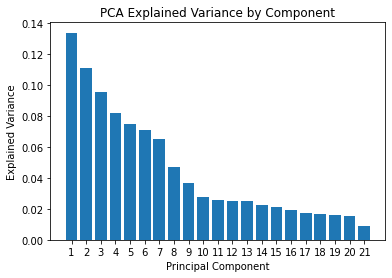

In [14]:
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.xticks(range(len(pca.explained_variance_ratio_)), list(range(1, len(pca.explained_variance_ratio_)+1)))
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.title('PCA Explained Variance by Component')
plt.show()
#On garde les 3 premiers axes (34% de variance)

In [15]:
print(pca.explained_variance_ratio_)

[0.13399978 0.11106973 0.09593934 0.0818614  0.07470469 0.07084229
 0.06553569 0.04684682 0.03662657 0.02739296 0.02596808 0.02539193
 0.02532337 0.02224487 0.02090897 0.01925875 0.0170835  0.01643905
 0.01576449 0.01509933 0.00890422]


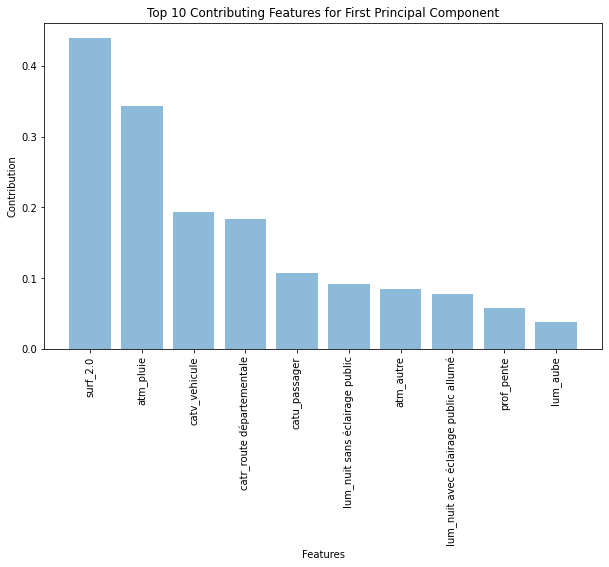

In [16]:
contrib = pca.components_[0]
feature_names = list(accidents_ohe.columns)

# Zip the feature names and contributions together and sort in descending order by contribution
sorted_contrib = sorted(zip(feature_names, contrib), key=lambda x: x[1], reverse=True)

# Select the top 10 contributions
top_10 = sorted_contrib[:10]

# Unzip the top 10 feature names and contributions
feature_names, contrib = zip(*top_10)

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the contribution of the first principal component
plt.bar(feature_names, contrib, alpha=0.5)

# Add labels and title
plt.xlabel("Features")
plt.xticks(rotation = 90)
plt.ylabel("Contribution")
plt.title("Top 10 Contributing Features for First Principal Component")

# Show the plot
plt.show()


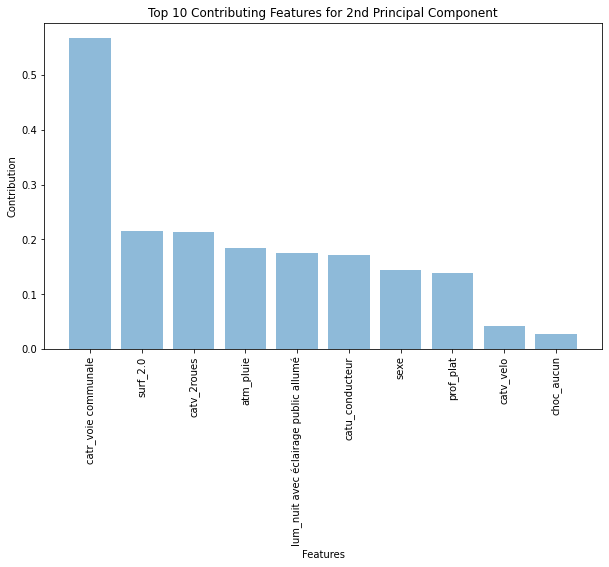

In [17]:
contrib = pca.components_[1]

feature_names = list(accidents_ohe.columns)

# Zip the feature names and contributions together and sort in descending order by contribution
sorted_contrib = sorted(zip(feature_names, contrib), key=lambda x: x[1], reverse=True)

# Select the top 10 contributions
top_10 = sorted_contrib[:10]

# Unzip the top 10 feature names and contributions
feature_names, contrib = zip(*top_10)

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the contribution of the second principal component
plt.bar(feature_names, contrib, alpha=0.5)

# Add labels and title
plt.xlabel("Features")
plt.ylabel("Contribution")
plt.xticks(rotation = 90)
plt.title("Top 10 Contributing Features for 2nd Principal Component")

# Show the plot
plt.show()


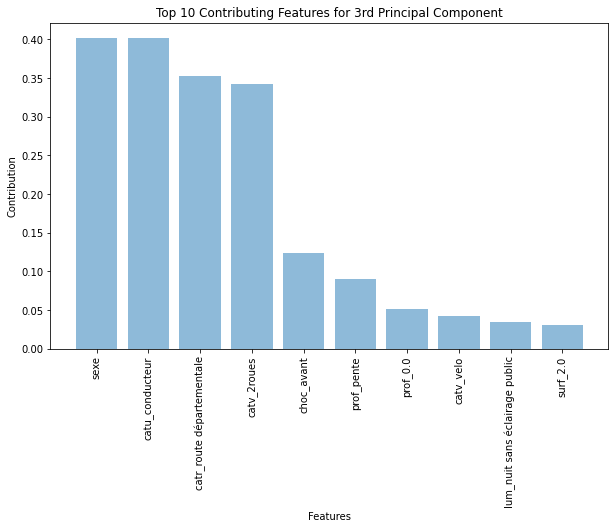

In [18]:
contrib = pca.components_[2]

feature_names = list(accidents_ohe.columns)

# Zip the feature names and contributions together and sort in descending order by contribution
sorted_contrib = sorted(zip(feature_names, contrib), key=lambda x: x[1], reverse=True)

# Select the top 10 contributions
top_10 = sorted_contrib[:10]

# Unzip the top 10 feature names and contributions
feature_names, contrib = zip(*top_10)

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the contribution of the 3rd principal component
plt.bar(feature_names, contrib, alpha=0.5)

# Add labels and title
plt.xlabel("Features")
plt.xticks(rotation = 90)
plt.ylabel("Contribution")
plt.title("Top 10 Contributing Features for 3rd Principal Component")

# Show the plot
plt.show()


# Decision Tree

In [19]:
accidents_ohe["age"] = df_ohe["age"]

In [20]:
Y = accidents['grav']
X = accidents_ohe

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import roc_auc_score, f1_score, log_loss
import graphviz
from sklearn import tree

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=60)

model score: 0.578


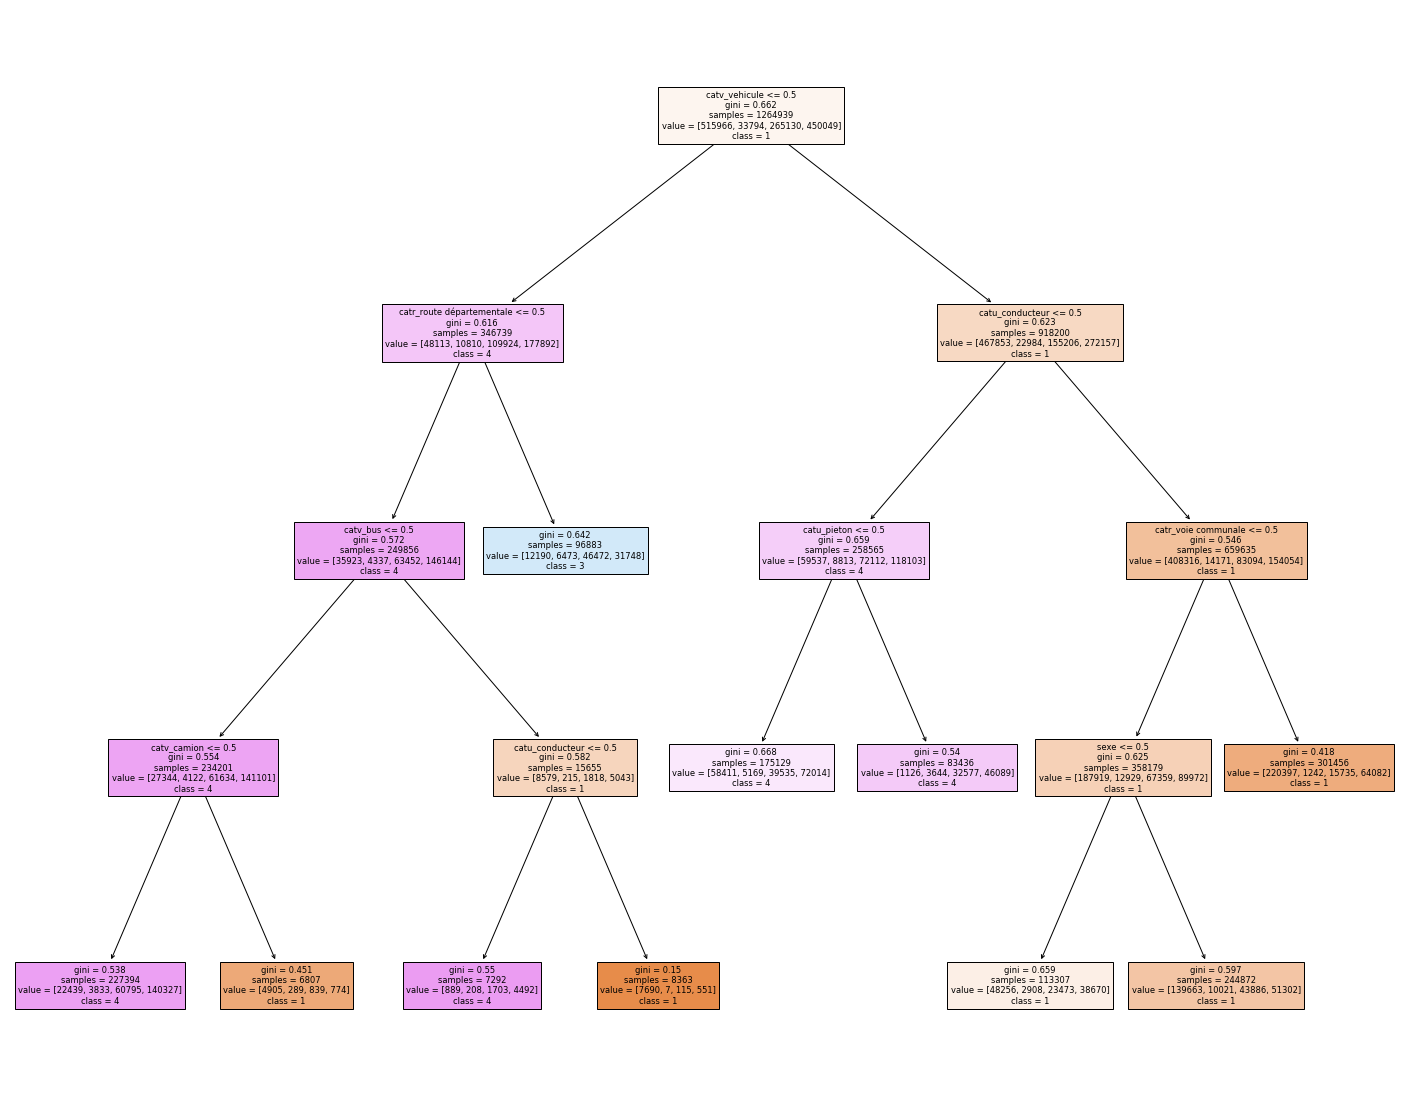

In [23]:
model = DecisionTreeClassifier(criterion='gini', splitter='best', min_weight_fraction_leaf=0.002, 
                               min_impurity_decrease=0.002, max_depth=5)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

dot_data = tree.export_graphviz(model, 
                filled=True, rounded=True,
                special_characters=True, feature_names = X_train.columns,class_names=['1','2', '3', '4'])
graph = graphviz.Source(dot_data)
graph

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model, 
                   feature_names = X_train.columns,
                   class_names=['1','2', '3', '4'],
                   filled=True)

predict_test = model.predict(X_test)
print("model score: %.3f" % model.score(X_test, y_test))
#print("model score AUC : %.3f" % roc_auc_score(y_test, predict_test))
#print("model log loss : %.3f" % log_loss(y_test, predict_test))

# Kmeans

In [24]:
inertias = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(reduced)
    inertias.append(kmeans.inertia_)

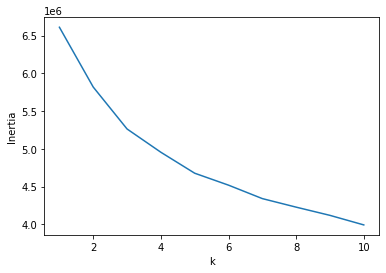

In [25]:
import matplotlib.pyplot as plt


# Plot the inertias as a line plot
plt.plot(range(1,11), inertias)

# Add labels to the plot
plt.xlabel('k')
plt.ylabel('Inertia')

# Show the plot
plt.show()

#On peut choisir entre 2 et 4 pour notre nombre de clusters

In [26]:

reduced = reduced.iloc[:, :3]

reduced_2c = KMeans(n_clusters = 2).fit(reduced)
reduced_3c = KMeans(n_clusters = 3).fit(reduced)
reduced_4c = KMeans(n_clusters = 4).fit(reduced)

reduced_4c.n_clusters

two_clusters = KMeans(n_clusters = 2)
three_clusters = KMeans(n_clusters = 3)
four_clusters = KMeans(n_clusters = 4)

two_clusters.fit(reduced)
three_clusters.fit(reduced)
four_clusters.fit(reduced)


labels_2c = two_clusters.predict(reduced)
labels_3c = three_clusters.predict(reduced)
labels_4c = four_clusters.predict(reduced)

In [27]:
x = reduced.values[:, 0]
y = reduced.values[:, 1]
z = reduced.values[:, 2]

In [28]:
df_3cluster = pd.DataFrame([x,y,z,labels_3c]).T.rename(columns={0: 'dim1',1:'dim2',2:'dim3',3:'cluster'})

In [29]:
df_3cluster

,dim1,dim2,dim3,cluster
0,0.426571,-0.677889,0.145835,2.0
1,-0.023396,-0.068571,1.172826,2.0
2,-0.176374,-0.740881,0.493443,2.0
3,0.037946,-1.095634,-0.167347,2.0
4,0.117112,-1.239683,-0.568868,2.0
...,...,...,...,...
1807051,0.118961,-0.521894,0.146132,2.0
1807052,0.223278,-0.603494,0.009469,2.0
1807053,0.437598,-0.958247,-0.651321,2.0
1807054,0.437598,-0.958247,-0.651321,2.0


[]

/Users/safadjerir/opt/anaconda3/lib/python3.8/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/safadjerir/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


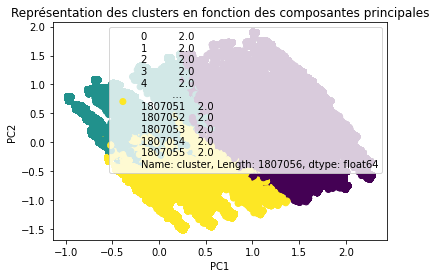

In [30]:
plt.figure()

plt.scatter(df_3cluster['dim1'],df_3cluster['dim2'],c = df_3cluster['cluster'], label=df_3cluster['cluster'])
plt.title("Représentation des clusters en fonction des composantes principales")
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.plot()


[]

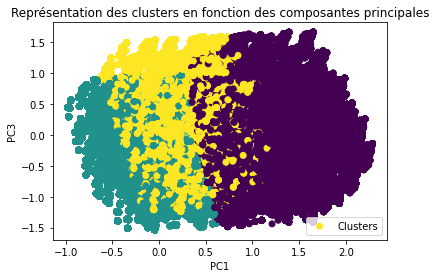

In [31]:
plt.figure()

plt.scatter(df_3cluster['dim1'],df_3cluster['dim3'],c = df_3cluster['cluster'], label='Clusters')
plt.legend()
plt.title("Représentation des clusters en fonction des composantes principales")
plt.xlabel("PC1")
plt.ylabel("PC3")
plt.plot()



[]

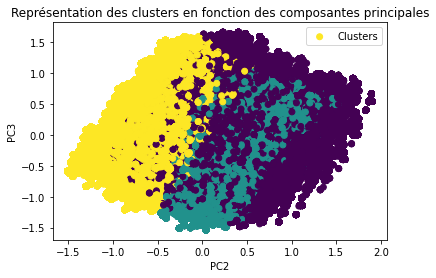

In [32]:
plt.figure()

plt.scatter(df_3cluster['dim2'],df_3cluster['dim3'],c = df_3cluster['cluster'], label='Clusters')
plt.legend()
plt.title("Représentation des clusters en fonction des composantes principales")
plt.xlabel("PC2")
plt.ylabel("PC3")
plt.plot()

In [33]:
accidents = accidents.reset_index().drop("index", axis=1)
accidents["cluster"] = df_3cluster["cluster"]

In [34]:
Cluster_0 = accidents[accidents['cluster']==0]
Cluster_1 = accidents[accidents['cluster']==1]
Cluster_2 = accidents[accidents['cluster']==2]

###### Nous remarquons que le cluster 2 contient le plus d'accidents à passages gravement blessé ou morts.

In [35]:
accid_grouped = pd.DataFrame(accidents.groupby('cluster').grav.value_counts(normalize=True)).rename(columns={'grav':'nb'}).reset_index()

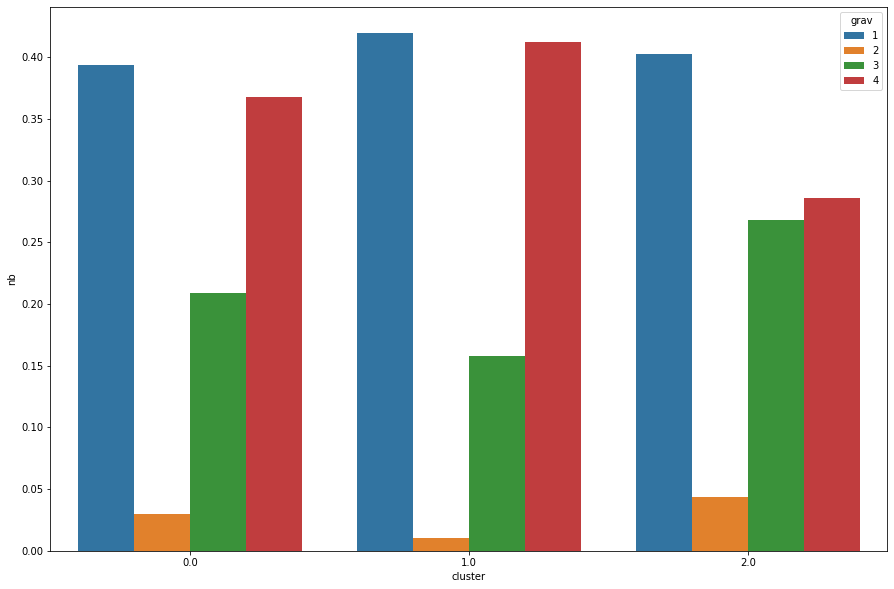

In [36]:
plt.figure(figsize=(15,10))
sns.barplot(accid_grouped["cluster"], accid_grouped["nb"], hue=accid_grouped["grav"])
plt.show()

<AxesSubplot: xlabel='cluster'>

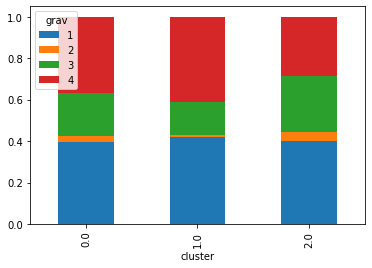

In [37]:

accidents.groupby('cluster')['grav'].value_counts(normalize=True).unstack('grav').plot.bar(stacked=True)


<AxesSubplot: xlabel='cluster'>

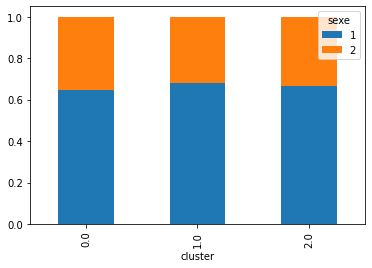

In [38]:
accidents.groupby('cluster')['sexe'].value_counts(normalize=True).unstack('sexe').plot.bar(stacked=True)

<AxesSubplot: xlabel='cluster'>

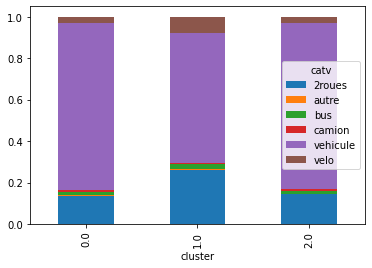

In [39]:
accidents.groupby('cluster')['catv'].value_counts(normalize=True).unstack('catv').plot.bar(stacked=True)

<AxesSubplot: xlabel='cluster'>

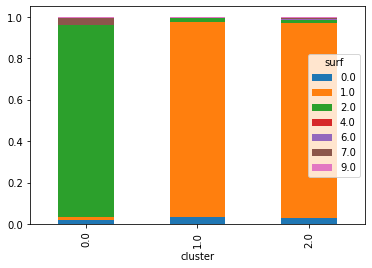

In [40]:
accidents.groupby('cluster')['surf'].value_counts(normalize=True).unstack('surf').plot.bar(stacked=True)

<AxesSubplot: xlabel='cluster'>

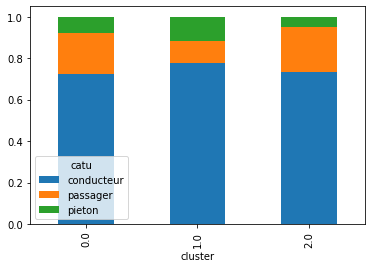

In [41]:
accidents.groupby('cluster')['catu'].value_counts(normalize=True).unstack('catu').plot.bar(stacked=True)

# data vis

In [42]:
from pandas_profiling import ProfileReport
import pandas as pd

#prof = ProfileReport(accidents)
#prof.to_file(output_file='rapport.html')
